In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append("../../data_pipeline/")

%load_ext lab_black

# Examining agricultural loss indicator

In [2]:
DATA_PATH = Path.cwd().parent / "data"

urban_rural_from_geocorr = pd.read_csv(
    DATA_PATH / "dataset/geocorr/usa.csv",
    dtype={"GEOID10_TRACT": str},
)

score_m = pd.read_csv(
    DATA_PATH / "score/csv/full/usa.csv",
    dtype={"GEOID10_TRACT": str},
    usecols=[
        "Expected agricultural loss rate (Natural Hazards Risk Index)",
        "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)",
        "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",
        "Urban Heuristic Flag",
        "Is low income and has a low percent of higher ed students?",
        "GEOID10_TRACT",
        "Total threshold criteria exceeded",
    ],
)

# Note that I downloaded this fresh because I am paranoid; this is not going to load on other computers and I am sorry!
nri_full = pd.read_csv(
    "/Users/emmausds/Desktop/current-work/NRI_Table_CensusTracts.csv",
    dtype={"TRACTFIPS": str},
    usecols=[
        "TRACTFIPS",
        "AGRIVALUE",
        "CWAV_EALA",
        "DRGT_EALA",
        "HAIL_EALA",
        "HWAV_EALA",
        "HRCN_EALA",
        "RFLD_EALA",
        "SWND_EALA",
        "TRND_EALA",
        "WFIR_EALA",
        "WNTW_EALA",
    ],
)

## Understanding our current implementation

In our current implementation, on average, urban areas have a higher NRI (scaled) and a higher percentile of the loss rate. The share of Rural and Urban tracts identified by this threshold is roughly equal. 

In [3]:
score_m.groupby("Urban Heuristic Flag")[
    [
        "Expected agricultural loss rate (Natural Hazards Risk Index)",
        "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)",
        "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?",
    ]
].mean()

,Expected agricultural loss rate (Natural Hazards Risk Index),Expected agricultural loss rate (Natural Hazards Risk Index) (percentile),"Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?"
Urban Heuristic Flag,,,
0.0,0.011502,0.486045,0.021132
1.0,0.016255,0.505159,0.018296


We can also look at the distribution of percentiles among the urban and rural tracts. This is very much not what I might expect -- I'd hope the rural areas were "flatter" in distribution than the urban areas.  

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


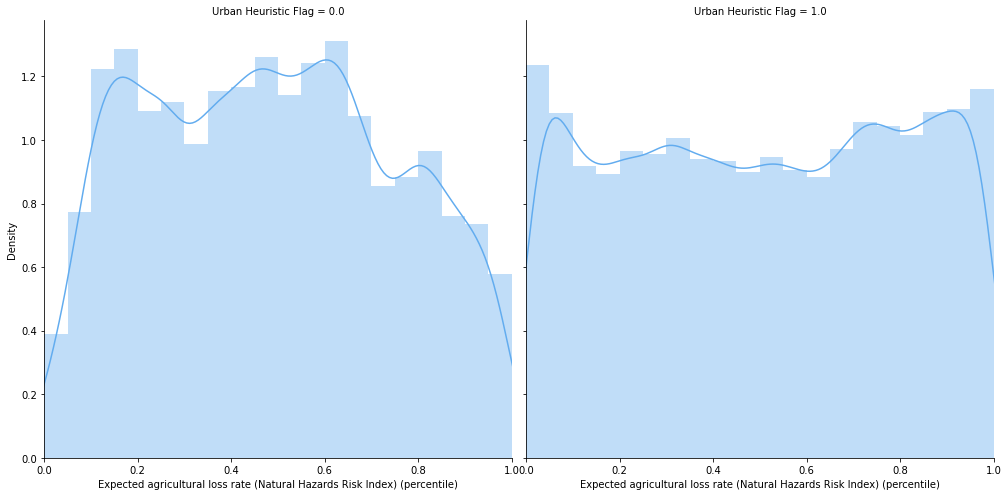

In [4]:
tmp = sns.FacetGrid(data=score_m, col="Urban Heuristic Flag", col_wrap=2, height=7)
tmp.map(
    sns.distplot,
    "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)",
    bins=20,
    kde=True,
    color="#62acef",
)
tmp.set(xlim=(0, 1.0))
plt.show()

But, if we look at just the raw loss rates, we see a very different distribution. This suggests to me that we are perhaps elevating the urban areas in our wealth-neutral metric. 

In [5]:
nri_with_flag = (
    nri_full.set_index("TRACTFIPS")
    .merge(
        urban_rural_from_geocorr.set_index("GEOID10_TRACT"),
        left_index=True,
        right_index=True,
        how="left",
    )
    .reset_index()
)

nri_with_flag["total_ag_loss"] = nri_with_flag.filter(like="EALA").sum(axis=1)
nri_with_flag["total_ag_loss_pctile"] = nri_with_flag["total_ag_loss"].rank(pct=True)

nri_with_flag.groupby("Urban Heuristic Flag")["total_ag_loss_pctile"].mean()

When we look at the distribution of agricultural value in census tracts that are urban and rural, we see that the agricultural value for urban tracts is quite skewed.

In [9]:
pd.options.display.float_format = "{:,.2f}".format
nri_with_flag.groupby("Urban Heuristic Flag")["AGRIVALUE"].quantile(
    q=np.arange(0, 1, step=0.1)
).unstack()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90
Urban Heuristic Flag,,,,,,,,,,
0.00,0.00,"407,226.75","1,305,567.65","2,586,000.00","4,411,909.10","7,385,163.62","11,582,526.63","18,205,814.38","30,706,464.84","56,067,604.96"
1.00,0.00,0.00,0.00,0.00,141.35,"1,812.91","9,755.31","44,319.94","202,972.50","1,060,793.40"


## Updating the metric

So we clip the values such that agrivalue is defined as the maximum of the tract's agricultural value AND the 10th percentile of rural tracts' agrivalues. When we do that, we see that a lot more (proportionally) rural tracts exceed the 90th percentile. 

In [10]:
final_left_clip = nri_with_flag[nri_with_flag["Urban Heuristic Flag"] == 0][
    "AGRIVALUE"
].quantile(0.1)

nri_with_flag[
    "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile, adjusted)"
] = (
    nri_with_flag["total_ag_loss"]
    / (nri_with_flag["AGRIVALUE"].clip(lower=final_left_clip))
).rank(
    pct=True
)

nri_with_flag[
    "Expected agricultural loss rate (Natural Hazards Risk Index) exceeds 90th percentile, adjusted"
] = (
    nri_with_flag[
        "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile, adjusted)"
    ]
    >= 0.9
)

nri_with_flag.groupby("Urban Heuristic Flag")[
    [
        "Expected agricultural loss rate (Natural Hazards Risk Index) exceeds 90th percentile, adjusted",
        "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile, adjusted)",
    ]
].mean().T

Urban Heuristic Flag,0.00,1.00
"Expected agricultural loss rate (Natural Hazards Risk Index) exceeds 90th percentile, adjusted",0.24,0.07
"Expected agricultural loss rate (Natural Hazards Risk Index) (percentile, adjusted)",0.77,0.43


The percentile distribution look a little better to me (but like, not fantastic)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


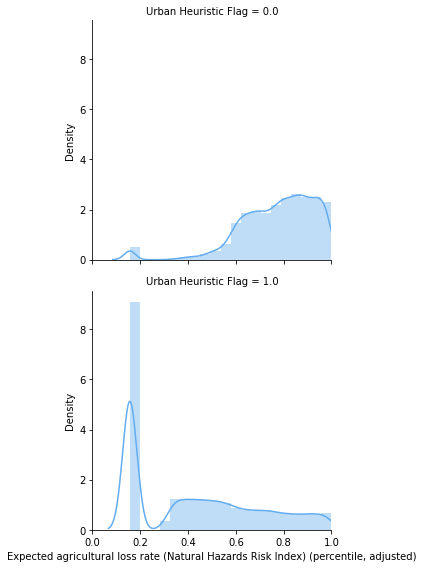

In [11]:
tmp = sns.FacetGrid(
    data=nri_with_flag, col="Urban Heuristic Flag", col_wrap=1, height=4
)
tmp.map(
    sns.distplot,
    "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile, adjusted)",
    bins=20,
    kde=True,
    color="#62acef",
)
tmp.set(xlim=(0, 1.0))
plt.show()

We can also look at the distribution of actually exceeding the threshold -- so also adding in the socioeconomic information from Score M. Note that *some tracts* are not shared between score M and the NRI data.

In [12]:
nri_with_flag["low_inc_low_highed"] = (
    nri_with_flag["TRACTFIPS"]
    .map(
        score_m.set_index("GEOID10_TRACT")[
            "Is low income and has a low percent of higher ed students?"
        ].to_dict()
    )
    .fillna(False)
)

nri_with_flag["would_exceed_threshold"] = (
    nri_with_flag["low_inc_low_highed"]
    & nri_with_flag[
        "Expected agricultural loss rate (Natural Hazards Risk Index) exceeds 90th percentile, adjusted"
    ]
)

In [24]:
pd.options.display.float_format = "{:.5f}".format
nri_with_flag.groupby("Urban Heuristic Flag")["would_exceed_threshold"].agg(
    ["sum", "mean"]
)

,sum,mean
Urban Heuristic Flag,,
0.00000,1190,0.08439
1.00000,1158,0.01982


In [25]:
score_m.groupby("Urban Heuristic Flag")[
    "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?"
].agg(["sum", "mean"])

,sum,mean
Urban Heuristic Flag,,
0.00000,298,0.02113
1.00000,1069,0.01830


This really increases the number of tracts identified - from just under 2% to just over 3% - and adds 259 tracts, removes 116.

In [15]:
display(
    nri_with_flag["would_exceed_threshold"].sum(),
    score_m[
        "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?"
    ].sum(),
)

all_ag_loss_tracts = nri_with_flag[nri_with_flag["would_exceed_threshold"]][
    "TRACTFIPS"
].unique()

all_scorem_tracts = score_m[score_m["Total threshold criteria exceeded"] > 0][
    "GEOID10_TRACT"
].unique()

display(len(set(all_ag_loss_tracts).difference(all_scorem_tracts)))

2348

1367

259

In [16]:
score_m["adjusted"] = score_m["Total threshold criteria exceeded"] - score_m[
    "Greater than or equal to the 90th percentile for expected agriculture loss rate, is low income, and has a low percent of higher ed students?"
].astype(int)

score_m_adjusted_tracts = set(score_m[score_m["adjusted"] > 0]["GEOID10_TRACT"]).union(
    all_ag_loss_tracts
)
display(len(set(all_scorem_tracts).difference(score_m_adjusted_tracts)))

116

## Scratch 
Choosing a left clip value

In [17]:
for threshold in np.arange(0, 1, 0.05):
    left_clip = nri_with_flag[nri_with_flag["Urban Heuristic Flag"] == 0][
        "AGRIVALUE"
    ].quantile(threshold)
    print("At threshold {:.2f}, minimum value is ${:,.0f}".format(threshold, left_clip))
    tmp_value = nri_with_flag["AGRIVALUE"].clip(lower=left_clip)
    nri_with_flag["total_ag_loss_pctile_{:.2f}".format(threshold)] = (
        nri_with_flag["total_ag_loss"] / tmp_value
    ).rank(pct=True)

At threshold 0.00, minimum value is $0
At threshold 0.05, minimum value is $82,341
At threshold 0.10, minimum value is $407,227
At threshold 0.15, minimum value is $822,946
At threshold 0.20, minimum value is $1,305,568
At threshold 0.25, minimum value is $1,881,536
At threshold 0.30, minimum value is $2,586,000
At threshold 0.35, minimum value is $3,375,394
At threshold 0.40, minimum value is $4,411,909
At threshold 0.45, minimum value is $5,719,970
At threshold 0.50, minimum value is $7,385,164
At threshold 0.55, minimum value is $9,228,310
At threshold 0.60, minimum value is $11,582,527
At threshold 0.65, minimum value is $14,421,393
At threshold 0.70, minimum value is $18,205,814
At threshold 0.75, minimum value is $23,497,859
At threshold 0.80, minimum value is $30,706,465
At threshold 0.85, minimum value is $40,827,282
At threshold 0.90, minimum value is $56,067,605
At threshold 0.95, minimum value is $86,129,868


In [18]:
tmp = (
    nri_with_flag.groupby("Urban Heuristic Flag")[
        [
            "total_ag_loss_pctile",
            "total_ag_loss_pctile_0.00",
            "total_ag_loss_pctile_0.05",
            "total_ag_loss_pctile_0.10",
            "total_ag_loss_pctile_0.15",
            "total_ag_loss_pctile_0.20",
            "total_ag_loss_pctile_0.25",
            "total_ag_loss_pctile_0.30",
            "total_ag_loss_pctile_0.35",
            "total_ag_loss_pctile_0.40",
            "total_ag_loss_pctile_0.45",
            "total_ag_loss_pctile_0.50",
            "total_ag_loss_pctile_0.55",
            "total_ag_loss_pctile_0.60",
            "total_ag_loss_pctile_0.65",
            "total_ag_loss_pctile_0.70",
            "total_ag_loss_pctile_0.75",
            "total_ag_loss_pctile_0.80",
            "total_ag_loss_pctile_0.85",
            "total_ag_loss_pctile_0.90",
            "total_ag_loss_pctile_0.95",
        ]
    ]
    .mean()
    .T
)

left_pctile = tmp.reset_index()["index"].str.split("_", expand=True)[4]
graph_data = (
    pd.concat([tmp.reset_index(), left_pctile], axis=1)
    .rename(
        columns={
            0: "Rural",
            1: "Urban",
            4: "Left clip value",
        }
    )
    .set_index("Left clip value")[["Rural", "Urban"]]
    .stack()
    .reset_index()
    .rename(columns={"level_1": "Tract classification", 0: "Average percentile"})
)

<AxesSubplot:xlabel='Left clip value', ylabel='Average percentile'>

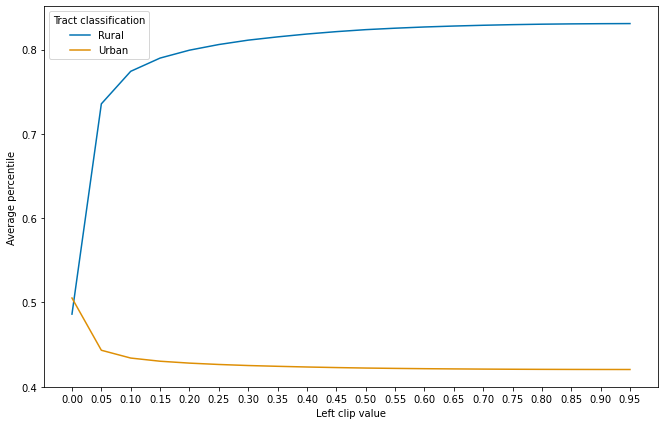

In [19]:
plt.figure(figsize=(11, 7))
sns.lineplot(
    x="Left clip value",
    y="Average percentile",
    hue="Tract classification",
    data=graph_data,
    palette="colorblind",
)

Note -- some tracts have a missing urban / rural flag. They get left out from the means. 

In [6]:
nri_with_flag["Urban Heuristic Flag"].value_counts(dropna=False)

1.0    58429
0.0    14101
NaN      209
Name: Urban Heuristic Flag, dtype: int64